This notebook has been adapted from the [spam example](https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/01_spam_tutorial.ipynb) of the [snorkel examples github](https://github.com/snorkel-team/snorkel-tutorials). Please visit the official snorkel tutorials [link](https://github.com/snorkel-team/snorkel-tutorials) for a more detailed and exhautive guide on how to use snorkel.<br>
This notebook demonstrates how to use snorkel for data labeling. Our goal here is to build a dataset which can be used to classify if a Youtube comment is Spam or Ham.


## Installing Dependencies

In [1]:
# To install only the requirements of this notebook, uncomment the lines below and run this cell

# ===========================

!pip install numpy==1.19.5
!pip install pandas==1.1.5
!pip install wget==3.2
!pip install matplotlib==3.2.2
!pip install utils==1.0.1
!pip install snorkel==0.9.6
!pip install scikit-learn==0.21.3
!pip install textblob==0.15.3
!pip install treedlib==0.1.3
!pip install numbskull==0.1.1
!pip install spacy==2.2.4

# ===========================

  Using cached pandas-1.1.5-cp36-cp36m-win_amd64.whl (8.7 MB)
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)
  Using cached matplotlib-3.2.2-cp36-cp36m-win_amd64.whl (9.2 MB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-win_amd64.whl (51 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached utils-1.0.1-py2.py3-none-any.whl (21 kB)
  Using cached snorkel-0.9.6-py3-none-any.whl (144 kB)
  Using cached torch-1.9.0-cp36-cp36m-win_amd64.whl (222.0 MB)
  Using cached munkres-1.1.4-py2.py3-none-any.whl (7.0 kB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Using cached networkx-2.3-py2.py3-none-any.whl
  Using cached protobuf-3.17.3-cp36-cp36m-win_amd64.whl (910 kB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Using cached grpcio-1.38.1-cp36-cp36m-win_amd64.whl (3.1 MB)
  Using cached absl_py-0.13.0-py3-none-any.whl (132 kB)
  Using cached Werkzeug-2.0.1-py3-none-any.whl (288 kB)
  Using cached dataclasses-0.8-py3-none-any.whl (19 kB

In [2]:
# To install the requirements for the entire chapter, uncomment the lines below and run this cell

# ===========================

# try :
#     import google.colab
#     !curl https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch2/ch2-requirements.txt | xargs -n 1 -L 1 pip install
# except ModuleNotFoundError :
#     !pip install -r "ch2-requirements.txt"

# ===========================

In [3]:
!pip install tensorflow==1.15
!pip install tensorboard==1.15
!python -m spacy download en_core_web_sm

  Using cached tensorflow-1.15.0-cp36-cp36m-win_amd64.whl (295.1 MB)
  Using cached wrapt-1.12.1-cp36-cp36m-win_amd64.whl
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached gast-0.2.2-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached h5py-3.1.0-cp36-cp36m-win_amd64.whl (2.7 MB)
  Using cached cached_property-1.5.2-py2.py3-none-any.whl (7.6 kB)
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011738 sha256=c111eabeab83a968de3ef5be42512577efa8886c072d9c98794baebb0caa2386
  Stored in directory: C:\Users\KUMARA~1\AppData\Local\Temp\pip-ephem-wheel-cache-5jeasita\wheels\b5\94\56\596d

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Dataset
Let's get the Youtube spam classification dataset from the UCI ML Repository archive. The link for the dataset can be found [here](http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip).

In [5]:
import os
import wget

import zipfile
import shutil

file_link = "http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip"

os.makedirs("content", exist_ok= True)
if not os.path.exists("content/YouTube-Spam-Collection-v1.zip"):
    wget.download(file_link, out="content/")
else:
    print("File already exists")

with zipfile.ZipFile("content/YouTube-Spam-Collection-v1.zip", 'r') as zip_ref:
    zip_ref.extractall("content/")

shutil.rmtree("content/__MACOSX")
os.remove("content/YouTube-Spam-Collection-v1.zip")
os.listdir("content")

100% [............................................................................] 163567 / 163567

['Youtube01-Psy.csv',
 'Youtube02-KatyPerry.csv',
 'Youtube03-LMFAO.csv',
 'Youtube04-Eminem.csv',
 'Youtube05-Shakira.csv']

Let's clone the necessary repos.

In [6]:
!git clone https://github.com/snorkel-team/snorkel-tutorials.git

source = "content/"
destination = "snorkel-tutorials/spam/data/"

os.makedirs(destination, exist_ok= True)

files = os.listdir(source)

for file in files:
    new_path = shutil.move(f"{source}/{file}", destination)

os.chdir("snorkel-tutorials/spam")

Cloning into 'snorkel-tutorials'...


## Making the necessary imports

In [7]:
import re
import glob

import utils

from snorkel.analysis import get_label_buckets

from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling.lf.nlp import nlp_labeling_function

from snorkel.preprocess import preprocessor
from snorkel.preprocess.nlp import SpacyPreprocessor

from snorkel.utils import probs_to_preds

from textblob import TextBlob

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def load_spam_dataset(load_train_labels: bool = False, split_dev_valid: bool = False):
    filenames = sorted(glob.glob("data/Youtube*.csv"))
    dfs = []
    for i, filename in enumerate(filenames, start=1):
        df = pd.read_csv(filename)
        # Lowercase column names
        df.columns = map(str.lower, df.columns)
        # Remove comment_id field
        df = df.drop("comment_id", axis=1)
        # Add field indicating source video
        df["video"] = [i] * len(df)
        # Rename fields
        df = df.rename(columns={"class": "label", "content": "text"})
        # Shuffle order
        df = df.sample(frac=1, random_state=123).reset_index(drop=True)
        dfs.append(df)

    df_train = pd.concat(dfs[:4])
    df_dev = df_train.sample(100, random_state=123)

    if not load_train_labels:
        df_train["label"] = np.ones(len(df_train["label"])) * -1
    df_valid_test = dfs[4]
    df_valid, df_test = train_test_split(
        df_valid_test, test_size=250, random_state=123, stratify=df_valid_test.label
    )

    if split_dev_valid:
        return df_train, df_dev, df_valid, df_test
    else:
        return df_train, df_test

In [9]:
df_train, df_test = load_spam_dataset()
print("Train")
display(df_train.head())
print('Test')
df_test.head()

Train


,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1


Test


,author,date,text,label,video
27,‫حلم الشباب‬‎,2015-05-25T23:42:49.533000,Check out this video on YouTube:﻿,1,5
194,MOHAMED THASLEEM,2015-05-24T07:03:59.488000,super music﻿,0,5
277,AlabaGames,2015-05-22T00:31:43.922000,Subscribe my channel I RECORDING FIFA 15 GOAL...,1,5
132,Manish Ray,2015-05-23T08:55:07.512000,This song is so beauty,0,5
163,Sudheer Yadav,2015-05-28T10:28:25.133000,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1,5


In [10]:
Y_test = df_test.label.values
Y_test[:5]

array([1, 0, 1, 0, 1], dtype=int64)

There are a few things to keep in mind with respect to the dataset:
1. HAM represents a NON-SPAM comment.
2. SPAM is a SPAM comment
3. ABSTAIN is for neither of the above

We initialise their respective values below


In [11]:
ABSTAIN = -1
HAM = 0
SPAM = 1

We need to find some pattern in the data, so as to create rules for labeling the data.<br>
Hence, we randomly display some rows of the dataset so that we can try to find some pattern in the text. 

In [12]:
df_train[["author", "text", "video"]].sample(20, random_state=2020)

,author,text,video
240,Lucas Trigo,WHATS UP EVERYONE!? :-) I Trying To Showcase M...,1
211,Blaze Rod,when i see this back in 2015 i ask myself how ...,3
228,MasterRobotTV,http://www.twitch.tv/zxlightsoutxz﻿,1
207,Franklin Music,Very Nice !﻿,3
153,lebanonwarior1,Song name??﻿,1
8,yenis maría Rodríguez,2015 LIKEEE﻿,3
62,RapStarz Coleman,Subscribe To Mê Please Guys,4
54,Jd Hurst,Check out this video on YouTube:﻿,3
353,jefflynnejp,Check out this video on YouTube: ﻿,3
406,eliška žáková,CUTE :)﻿,3


An example for how a labeling function can be defined , anything that might match the pattern of a spam message can be used , here http is an example to show as many spam comments may contain links

In [13]:
@labeling_function()
def lf_contains_link(x):
    # Return a label of SPAM if "http" in comment text, otherwise ABSTAIN
    return SPAM if "http" in x.text.lower() else ABSTAIN

Defining labeling functions to check strings such as 'check', 'check out', 'http', 'my channel', 'subscribe'<br>
Try to write your own labeling functions too.

In [14]:
@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

@labeling_function()
def my_channel(x):
    return SPAM if "my channel" in x.text.lower() else ABSTAIN

@labeling_function()
def if_subscribe(x):
    return SPAM if "subscribe" in x.text.lower() else ABSTAIN

Using **LFApplier** to use our labelling fucntions with pandas dataframe object.

these labeling functions can also be used on columns other than 'text'

In [15]:
lfs = [check_out, check, lf_contains_link, my_channel, if_subscribe]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|████████████████████████████████████████████████████████████████████████████| 1586/1586 [00:00<00:00, 6198.71it/s]


In [16]:
L_train

array([[-1, -1,  1, -1, -1],
       [-1, -1, -1, -1,  1],
       [-1,  1, -1, -1, -1],
       ...,
       [ 1,  1, -1,  1,  1],
       [-1,  1, -1, -1,  1],
       [ 1,  1, -1, -1, -1]])

_Coverage_ is the fraction of the dataset the labeling function labels.

In [17]:
coverage_check_out, coverage_check, coverage_link, coverage_my_channel, coverage_subscribe= (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")
print(f"link coverage: {coverage_link * 100:.1f}%")
print(f"my_channel coverage: {coverage_my_channel * 100:.1f}%")
print(f"if_subscribe coverage: {coverage_subscribe * 100:.1f}%")

check_out coverage: 21.4%
check coverage: 25.8%
link coverage: 11.9%
my_channel coverage: 7.0%
if_subscribe coverage: 12.7%


Before we procees further, let us understand a bit of jargon with respect to the summary of the _LFAnalysis_
1. Polarity - set of unique labels that the labeling function outputs (excluding Abstains)

2. Overlaps - where there is atleast one common entry for more than one labeling functions i.e the labeling fucntions agree upon the value to be returned

3. Conflicts - where the labeling functions disagree upon the value to be returned

In [18]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
lf_contains_link,2,[1],0.119168,0.011980,0.0
my_channel,3,[1],0.069987,0.057377,0.0
if_subscribe,4,[1],0.127364,0.054855,0.0


Trying and checking the results by filtering out the matching rows and checking for false positives 

In [19]:
# display(df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=2020))
# display(df_train.iloc[L_train[:, 2] == SPAM].sample(10, random_state=2020))
df_train.iloc[L_train[:, 3] == SPAM].sample(10, random_state=2020)

,author,date,text,label,video
34,TA Stealth,2015-03-11T01:25:46.234000,Cool Video LMFAOVEVO! You should check out my ...,-1.0,3
288,ItsJoey Dash,2014-07-22T10:02:25.925000,EVERYONE PLEASE GO SUBSCRIBE TO MY CHANNEL OR ...,-1.0,3
36,Victor Gamer,2015-04-13T02:00:20.152000,View 851.247.920<br /><br /> Best youtube Vide...,-1.0,3
263,Backup Plus,2014-11-03T17:39:07,Suscribe My Channel Please XD lol﻿,-1.0,1
386,ItsJoey Dash,2014-07-22T10:04:05.755000,EVERYONE PLEASE SUBSCRIBE TO MY CHANNEL OR CAN...,-1.0,3
404,M.E.S,NaN,hey its M.E.S here I&#39;m a young up and comi...,-1.0,4
341,superfacoo,NaN,Hey? Everyone Please take a moment to read thi...,-1.0,4
229,Terry-Lee Mackenney,NaN,Hi Guys im an Upcoming Rapper if you could che...,-1.0,4
157,TopMusicWorld HD,2014-10-19T23:27:50,Please Subscribe In My Channel →﻿,-1.0,2
48,Kiddy Kidso,2014-01-19T16:49:52,Check my channel please! And listen to the bes...,-1.0,1


Combining two labeling functions and checking the results 

In [20]:
#buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
#buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
buckets = get_label_buckets(L_train[:, 0], L_train[:, 3])

df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
230,LBEProductions,2014-11-12T01:40:22,Hey guys can you check my channel out plz. I d...,-1.0,1
287,DERRICK HANFORD,2014-12-05T22:52:29.316000,White people are going extinct for more inform...,-1.0,3
113,Carlos Thegamer,2013-12-01T01:20:21,subscribe to my channel people :D﻿,-1.0,1
301,Ractive,NaN,i been working so hard for the past 60 days to...,-1.0,4
246,Patrik Gybka,2015-05-05T09:32:04.687000,SUBSCRIBE MY CHANNEL PLEASE LOL PRO PLAYS)﻿,-1.0,3
8,Youyou A.,2014-10-21T15:20:49,"I make guitar covers, please have a look at my...",-1.0,2
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,-1.0,2
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",-1.0,2
171,MR magic man,2014-09-25T10:42:47,Please look at my channel﻿,-1.0,2
10,Dany PK,NaN,SUBSCRIBE TO MY CHANNEL X PLEASE!. SPARE,-1.0,4


**Regex Based Labeling Functions:** Using regular expressions to make the labeling functions more adaptive over differnt variations of the pattern string and repeating the the same process as above.<br>

Please feel free to find out patterns and write similar functions for 'http','subscribe', etc and if possible send a pull request.

In [21]:
#using regular expressions
@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

In [22]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|███████████████████████████████████████████████████████████████████████████| 1586/1586 [00:00<00:00, 12821.13it/s]


In [23]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


In [24]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=2020)

,author,date,text,label,video
112,ArioseRose,2014-11-13T15:20:31,"Don't mind me, I'm just checking what the view...",-1.0,1
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,-1.0,2
190,Warrdrew,2014-11-07T07:46:57,I'm here to check the views.. holy shit﻿,-1.0,1
146,Bob Kanowski,2013-11-28T12:33:27,i turned it on mute as soon is i came on i jus...,-1.0,1
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",-1.0,1
191,RezAIIDay,2014-11-05T22:50:58,Such a good song ans Katy sounds great over th...,-1.0,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1
162,Owen Lai,2013-12-01T04:51:52,just checking the views﻿,-1.0,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,-1.0,1
322,Minecraft-Viasat,2014-11-03T14:38:53,Check my channel﻿,-1.0,1


Let's use a 3rd party model, TextBlob in this case, to write a labeling function. Snorkel makes this very simple to implement.

In [25]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [26]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN


In [27]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)


100%|█████████████████████████████████████████████████████████████████████████████| 1586/1586 [00:02<00:00, 607.68it/s]


In [28]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


## Writing more labeling functions

Single labeling functions arent enough to test the entire databsase with accuracy as they do not have enough coverage, we usually need to combine differnt labeling functions(more rubost and accurate ones) to get this done.

**Keyword based labeling fucntions**: These are similar to the ones used befeore with the labeling_fucntion decorator. here we just make a few changes

In [29]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)


Modifying the above functions to use regualr expressions too would be an interesting exercise which we will leave to the reader.

Having other methods such as a Rule of Thumb or Heuristics(length of text) could help too. These are not extremely accurate but will get the job done to a certain extent.

An example is given below

In [30]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

We can also use NLP preprocessors such as spaCy to enrich our data and provide us with more fields to work on which will make the labeling a bit easier . 

In [31]:
# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [32]:
#snorkel has a pre built labeling function like decorator that uses spaCy as it is a very common nlp preprocessor

@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN


## Outputs
Let's move onto learning how we can go about combining labeling function outputs with labeling models.



In [33]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]


In [34]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 64.66it/s]


In [35]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.186003,0.110340
keyword_subscribe,1,[1],0.127364,0.107818,0.068096
keyword_http,2,[1],0.119168,0.102144,0.083228
keyword_please,3,[1],0.112232,0.109710,0.057377
keyword_song,4,[0],0.141866,0.111602,0.043506
regex_check_out,5,[1],0.233922,0.133039,0.086381
short_comment,6,[0],0.225725,0.144388,0.074401
has_person_nlp,7,[0],0.082598,0.060530,0.025221
textblob_polarity,8,[0],0.035309,0.032156,0.005044
textblob_subjectivity,9,[0],0.357503,0.261665,0.160151


We plot a histogram to get an idea about the coverages of the labeling functions

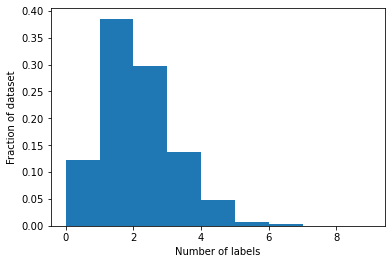

In [36]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We now convert the labels from our labeling functions to a single noise-aware probabilistic label per data. we do so by taking a majority vote on what the data should be labeled as .i.e if more labeling functions agree that the text/data is spam , then we label it as spam

In [37]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [38]:
preds_train

array([ 1,  1, -1, ...,  1,  1,  1])

However there may be functions that are correlated and might give a false sense of majority , to handle this we use a differernt snorkel label model to comine inputs of the labeling functions.

In [39]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [40]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   84.0%
Label Model Accuracy:     86.4%


We plot another graph to see the confidences that each data point is a spam

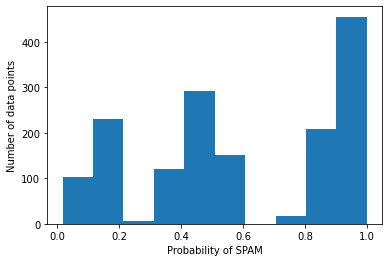

In [41]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()

probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])


There might be some data which do not get any label from the functions , we filter them out as follows

In [42]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## Training a classifier
In this section we use the probabilistic training labels we generated to train a classifier. for demonstration we use Scikit-Learn.<br>
_Note:Do not worry if you do not understand what a classifier is. We cover all of this in Chapter 4. Please read Ch4 and look at the jupyter notebooks in Ch4._

In [43]:
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())


In [44]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [45]:
sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")


Test Accuracy: 94.0%


We have just scratched the surface on what snorkel can do. We highly recommend going through their [github](https://github.com/snorkel-team/snorkel) and [tutorials](https://github.com/snorkel-team/snorkel-tutorials).